## A brief introduction and background about AI4PDEs

The AI4PDEs code solves discretised systems with untrained neural networks. It is used to simulate incompressible Navier-Stokes equations which can be written in 2D as, 
$$
\frac{\partial \mathbf{q}}{\partial t} + u\frac{\partial \mathbf{q}}{\partial x} +  v\frac{\partial \mathbf{q}}{\partial y} + 
\sigma \mathbf{q} - \nu \nabla \cdot \nabla \mathbf{q} = -\nabla p \,
$$

$$
\nabla  \cdot \mathbf{q} = \mathbf{0} \,
$$
in which $\mathbf{q}=(u \;v)^T$ in 2D and $\mathbf{q}=(u\;v\;w)^T$ in 3D, $p$ is the pressure, $\sigma$ is an absorption term and $\nu$ is the viscosity coefficient. A projection based solution method formed by manipulating the 
discretised equations which results in the following procedure,
1. Solve for $\mathbf{q}^{n+1}$ using the two-step approach outlined for the Burgers and advection-diffusion equation but treating the term involving $\sigma$ fully implicitly:
$$
\frac{\mathbf{q}^{n+1} -\mathbf{q}^{n} }{\Delta t} + u^n\frac{\partial \mathbf{q}^{n+\frac{1}{2}} }{\partial x} +  v^n\frac{\partial \mathbf{q}^{n+\frac{1}{2}} }{\partial y} + 
\sigma \mathbf{q}^{n+1} - \nu \nabla \cdot \nabla \mathbf{q}^{n+\frac{1}{2}} = -\nabla p^n \,
$$
2. Solve for pressure correction $\Delta p$:
$$ 
\nabla^2 \Delta p = -\frac{1}{\Delta t} \nabla \cdot \mathbf{q}^{n+1}  
$$
3. Solve for the velocity correction $\Delta \mathbf{q}$ using the U-net structured multigrid solver
$$
\Delta \mathbf{q} = -\Delta t \nabla \Delta p. 
$$
4. Update pressure solution: $p^{n+1} = p^n + \Delta p$
5. Update velocity solution: $\mathbf{q}^{n+1} \leftarrow \mathbf{q}^{n+1} + \Delta \mathbf{q}$

## More details can be found in our recent publications,
+
Phillips TR, Heaney CE, Chen B, Buchan AG, Pain CC. [Solving the discretised neutron diffusion equations using neural networks](https://doi.org/10.1002/nme.7321). International Journal for Numerical Methods in Engineering. 2023 Nov 15;124(21):4659-86. 
+
Phillips TR, Heaney CE, Chen B, Buchan AG, Pain CC. [Solving the Discretised Boltzmann Transport Equations using Neural Networks: Applications in Neutron Transport](https://doi.org/10.48550/arXiv.2301.09991). arXiv preprint arXiv:2301.09991. 2023 Jan 24. 
+
Chen B, Heaney CE, Pain CC. [Using AI libraries for Incompressible Computational Fluid Dynamics](https://doi.org/10.48550/arXiv.2402.17913). arXiv preprint arXiv:2402.17913. 2024 Feb 27. 
+
Chen B, Heaney CE, Gomes JL, Matar OK, Pain CC. [Solving the Discretised Multiphase Flow Equations with Interface Capturing on Structured Grids Using Machine Learning Libraries]( https://doi.org/10.1016/j.cma.2024.116974). Computer Methods in Applied Mechanics and Engineering. 2024 June 1; 426: 0045-7825.

Contact: Prof Christopher C. Pain (c.pain@imperial.ac.uk), Dr Claire E. Heaney (c.heaney@imperial.ac.uk), Dr Boyang Chen (boyang.chen16@imperial.ac.uk). [Applied Modelling and Computation Group](https://www.imperial.ac.uk/earth-science/research/research-groups/amcg/), Department of Earth Science and Engineering, Imperial College London

## Load modules from Python/Pytorch

In [1]:
import os
import numpy as np 
import pandas as pd
import time 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

# Check if GPU is available 
is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
print(is_gpu)

True


## Load modules from AI4PDEs

In [2]:
from AI4PDEs_utils  import create_tensors_3D, create_tensors_2D, get_weights_linear_2D, get_weights_linear_3D
from AI4PDEs_bounds import boundary_condition_3D_u, boundary_condition_3D_v, boundary_condition_3D_w
from AI4PDEs_bounds import boundary_condition_3D_p, boundary_condition_3D_k, boundary_condition_3D_cw

## Initialise numerical parameter

In [3]:
dt = 0.5                                # Time step (s)
dx = 1.0 ; dy = 1.0 ; dz = 1.0          # Grid size (m)
Re = 0.15                               # Viscosity 
ub = -1.0                               # Inflow speed (m/s)
nx = 512 ; ny = 512 ; nz = 64           # Grid point
nlevel = int(math.log(nz, 2)) + 1       # Multigrid level
ntime = 500                             # Time step
n_out = 100                             # Time step to save results 
n_check = 50                            # Time step to check residual
iteration = 5                           # Multigrid iteration
filepath = 'test_buildings'             # filepath to save results 
T_stat = True                           # Generate time histories at specific points  
L_save = True                           # Save results
bias_initializer = torch.tensor([0.0])  # Initial bias as 0 for NNs 

In [4]:
if not os.path.exists(filepath):
    os.makedirs(filepath)

## Initialise numerical parameter

In [5]:
[w1, w2, w3, w4, wA, w_res, diag] = get_weights_linear_3D(dx)

All the required 3D filters have been created successfully!
w1    => second order derivative  - (1,1,3,3,3)
w2    => first order derivative x - (1,1,3,3,3)
w3    => first order derivative y - (1,1,3,3,3)
w4    => first order derivative z - (1,1,3,3,3)
wA    => second order derivative  - (1,1,3,3,3)
w_res => Restriction operation    - (1,1,3,3,3)
diag  => Diagonal component of wA - (1,1,1,1,1)


## Establish AI4CFD Neural Network

In [6]:
class AI4Urban(nn.Module):
    """docstring for AI4Urban"""
    def __init__(self):
        super(AI4Urban, self).__init__()
        # self.arg = arg
        self.xadv = nn.Conv3d(1, 1, kernel_size=3, stride=1, padding=0)
        self.yadv = nn.Conv3d(1, 1, kernel_size=3, stride=1, padding=0)
        self.zadv = nn.Conv3d(1, 1, kernel_size=3, stride=1, padding=0)
        self.diff = nn.Conv3d(1, 1, kernel_size=3, stride=1, padding=0)

        self.A = nn.Conv3d(1, 1, kernel_size=3, stride=1, padding=0)
        self.res = nn.Conv3d(1, 1, kernel_size=2, stride=2, padding=0)  
        self.prol = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'),)

        self.A.weight.data = wA
        self.res.weight.data = w_res
        self.diff.weight.data = w1
        self.xadv.weight.data = w2
        self.yadv.weight.data = w3
        self.zadv.weight.data = w4

        self.A.bias.data = bias_initializer
        self.res.bias.data = bias_initializer
        self.diff.bias.data = bias_initializer
        self.xadv.bias.data = bias_initializer
        self.yadv.bias.data = bias_initializer
        self.zadv.bias.data = bias_initializer

    def solid_body(self, values_u, values_v, values_w, sigma, dt):
        values_u = values_u / (1 + dt * sigma) 
        values_v = values_v / (1 + dt * sigma) 
        values_w = values_w / (1 + dt * sigma) 
        return values_u, values_v, values_w

    def F_cycle_MG(self, values_uu, values_vv, values_ww, values_p, values_pp, iteration, diag, dt, nlevel):
        b = -(self.xadv(values_uu) + self.yadv(values_vv) + self.zadv(values_ww)) / dt
        for MG in range(iteration):
              w = torch.zeros((1,1,1,1,1), device=device)
              r = self.A(boundary_condition_3D_p(values_p, values_pp)) - b 
              r_s = []  
              r_s.append(r)
              for i in range(1,nlevel-1):
                     r = self.res(r)
                     r_s.append(r)
              for i in reversed(range(1,nlevel-1)):
                     ww = boundary_condition_3D_cw(w)
                     w = w - self.A(ww) / diag + r_s[i] / diag
                     w = self.prol(w)         
              values_p = values_p - w
              values_p = values_p - self.A(boundary_condition_3D_p(values_p, values_pp)) / diag + b / diag
        return values_p, w, r

    def PG_vector(self, values_uu, values_vv, values_ww, values_u, values_v, values_w, ADx_u, ADy_u, ADz_u, ADx_v, ADy_v, ADz_v, ADx_w, ADy_w, ADz_w, AD2_u, AD2_v, AD2_w):
        k_u = 0.1 * dx * torch.abs(1/3 * dx**-3 * (torch.abs(values_u) * dx + torch.abs(values_v) * dy + torch.abs(values_w) * dz) * AD2_u) / \
            (1e-03 + (torch.abs(ADx_u) * dx**-3 + torch.abs(ADy_u) * dx**-3 + torch.abs(ADz_u) * dx**-3) / 3)

        k_v = 0.1 * dy * torch.abs(1/3 * dx**-3 * (torch.abs(values_u) * dx + torch.abs(values_v) * dy + torch.abs(values_w) * dz) * AD2_v) / \
            (1e-03 + (torch.abs(ADx_v) * dx**-3 + torch.abs(ADy_v) * dx**-3 + torch.abs(ADz_v) * dx**-3) / 3)

        k_w = 0.1 * dz * torch.abs(1/3 * dx**-3 * (torch.abs(values_u) * dx + torch.abs(values_v) * dy + torch.abs(values_w) * dz) * AD2_w) / \
            (1e-03 + (torch.abs(ADx_w) * dx**-3 + torch.abs(ADy_w) * dx**-3 + torch.abs(ADz_w) * dx**-3) / 3)

        k_u = torch.clamp_max(k_u, 2.0) / (1 + dt * sigma) 
        k_v = torch.clamp_max(k_v, 2.0) / (1 + dt * sigma) 
        k_w = torch.clamp_max(k_w, 2.0) / (1 + dt * sigma) 

        k_uu = boundary_condition_3D_k(k_u) 
        k_vv = boundary_condition_3D_k(k_v)  
        k_ww = boundary_condition_3D_k(k_w)

        k_x = 0.5 * (k_u * AD2_u + self.diff(values_uu * k_uu) - values_u * self.diff(k_uu))
        k_y = 0.5 * (k_v * AD2_v + self.diff(values_vv * k_vv) - values_v * self.diff(k_vv))
        k_z = 0.5 * (k_w * AD2_w + self.diff(values_ww * k_ww) - values_w * self.diff(k_ww))
        return k_x, k_y, k_z

    def forward(self, values_u, values_uu, values_v, values_vv, values_w, values_ww, values_p, values_pp, b_uu, b_vv, b_ww, dt, iteration):
    # Padding velocity vectors 
        values_uu = boundary_condition_3D_u(values_u,values_uu,ub)  
        values_vv = boundary_condition_3D_v(values_v,values_vv,ub)   
        values_ww = boundary_condition_3D_w(values_w,values_ww,ub) 
        values_pp = boundary_condition_3D_p(values_p,values_pp) 

        Grapx_p = self.xadv(values_pp) * dt ; Grapy_p = self.yadv(values_pp) * dt ; Grapz_p = self.zadv(values_pp) * dt  
        ADx_u = self.xadv(values_uu) ; ADy_u = self.yadv(values_uu) ; ADz_u = self.zadv(values_uu)
        ADx_v = self.xadv(values_vv) ; ADy_v = self.yadv(values_vv) ; ADz_v = self.zadv(values_vv)
        ADx_w = self.xadv(values_ww) ; ADy_w = self.yadv(values_ww) ; ADz_w = self.zadv(values_ww)
        AD2_u = self.diff(values_uu) ; AD2_v = self.diff(values_vv) ; AD2_w = self.diff(values_ww)
    # First step for solving uvw
        [k_x,k_y,k_z] = self.PG_vector(values_uu, values_vv, values_ww, values_u, values_v, values_w, 
                                       ADx_u, ADy_u, ADz_u, ADx_v, ADy_v, ADz_v, ADx_w, ADy_w, ADz_w, AD2_u, AD2_v, AD2_w)

        b_u = values_u + 0.5 * (Re * k_x * dt - values_u * ADx_u * dt - values_v * ADy_u * dt - values_w * ADz_u * dt) - Grapx_p
        b_v = values_v + 0.5 * (Re * k_y * dt - values_u * ADx_v * dt - values_v * ADy_v * dt - values_w * ADz_v * dt) - Grapy_p
        b_w = values_w + 0.5 * (Re * k_z * dt - values_u * ADx_w * dt - values_v * ADy_w * dt - values_w * ADz_w * dt) - Grapz_p
    # Solid body
        [b_u, b_v, b_w] = self.solid_body(b_u, b_v, b_w, sigma, dt)
    # Padding velocity vectors 
        b_uu = boundary_condition_3D_u(b_u,b_uu,ub) 
        b_vv = boundary_condition_3D_v(b_v,b_vv,ub)  
        b_ww = boundary_condition_3D_w(b_w,b_ww,ub) 

        ADx_u = self.xadv(b_uu) ; ADy_u = self.yadv(b_uu) ; ADz_u = self.zadv(b_uu)
        ADx_v = self.xadv(b_vv) ; ADy_v = self.yadv(b_vv) ; ADz_v = self.zadv(b_vv)
        ADx_w = self.xadv(b_ww) ; ADy_w = self.yadv(b_ww) ; ADz_w = self.zadv(b_ww)
        AD2_u = self.diff(b_uu) ; AD2_v = self.diff(b_vv) ; AD2_w = self.diff(b_ww)

        [k_x,k_y,k_z] = self.PG_vector(b_uu, b_vv, b_ww, b_u, b_v, b_w, 
                                       ADx_u, ADy_u, ADz_u, ADx_v, ADy_v, ADz_v, ADx_w, ADy_w, ADz_w, AD2_u, AD2_v, AD2_w)   
    # Second step for solving uvw   
        values_u = values_u + Re * k_x * dt - b_u * ADx_u * dt - b_v * ADy_u * dt - b_w * ADz_u * dt - Grapx_p  
        values_v = values_v + Re * k_y * dt - b_u * ADx_v * dt - b_v * ADy_v * dt - b_w * ADz_v * dt - Grapy_p  
        values_w = values_w + Re * k_z * dt - b_u * ADx_w * dt - b_v * ADy_w * dt - b_w * ADz_w * dt - Grapz_p
    # Solid body
        [values_u, values_v, values_w] = self.solid_body(values_u, values_v, values_w, sigma, dt)
    # pressure
        values_uu = boundary_condition_3D_u(values_u,values_uu,ub)
        values_vv = boundary_condition_3D_v(values_v,values_vv,ub) 
        values_ww = boundary_condition_3D_w(values_w,values_ww,ub)  
        [values_p, w ,r] = self.F_cycle_MG(values_uu, values_vv, values_ww, values_p, values_pp, iteration, diag, dt, nlevel)
    # Pressure gradient correction    
        values_pp = boundary_condition_3D_p(values_p, values_pp)        
        values_u = values_u - self.xadv(values_pp) * dt ; values_v = values_v - self.yadv(values_pp) * dt ; values_w = values_w - self.zadv(values_pp) * dt      
    # Solid body
        [values_u, values_v, values_w] = self.solid_body(values_u, values_v, values_w, sigma, dt)
        return values_u, values_v, values_w, values_p, w, r

## Send the model to GPU

In [7]:
AI4Urban = AI4Urban().to(device)

## Create initial tensors 

In [8]:
values_u, values_v, values_w, values_p, values_uu, values_vv, values_ww, values_pp, b_uu, b_vv, b_ww = create_tensors_3D(nx, ny, nz)

All the required 3D tensors have been created successfully!
values_u  => u velocity [first step]  - (1,1,nz,ny,nx)
values_v  => v velocity [first step]  - (1,1,nz,ny,nx)
values_w  => w velocity [first step]  - (1,1,nz,ny,nx)
values_p  => pressure                 - (1,1,nz,ny,nx)
b_uu      => v velocity [second step] - (1,1,nz+2,ny+2,nx+2)
b_vv      => v velocity [second step] - (1,1,nz+2,ny+2,nx+2)
b_ww      => w velocity [second step] - (1,1,nz+2,ny+2,nx+2)
values_uu => u velocity [first step]  - (1,1,nz+2,ny+2,nx+2)
values_vv => v velocity [first step]  - (1,1,nz+2,ny+2,nx+2)
values_ww => w velocity [first step]  - (1,1,nz+2,ny+2,nx+2)
values_pp => pressure                 - (1,1,nz+2,ny+2,nx+2)


## Loading buildings mesh

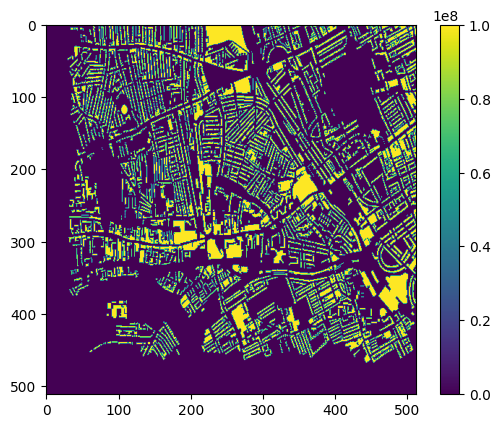

In [9]:
mesh = np.load("Mesh_buildings.npy")
sigma = torch.zeros_like(values_u)
for i in range(nz):
    sigma[0,0,i,:,:] = torch.tensor(mesh[0,180:692,240:752,i,0])
sigma = sigma.transpose_(4, 3)
sigma = torch.flip(sigma, [3])
sigma = torch.where(sigma == 0, torch.tensor(1e08, dtype=torch.float32, device=device), torch.tensor(0, dtype=torch.float32, device=device))
plt.imshow(sigma[0,0,4,:,:].cpu())
plt.colorbar()

## Run AI4Urban solver

In [10]:
start = time.time()
print("========================================================================")
print("Welcome to AI4CFD solver that will generate flow past buildings for you!")
print("========================================================================")
print("Summarising basic numerical setup before running AI4CFD code............")
print(f'inflow speed from left to right --- {-ub} (m/s)')
print(f'Time step ------------------------- {dt} (s)')
print(f'Grid size ------------------------- {dx} (m)')
if L_save == True:
    print("You are saving spatial results!")
print("========================================================================")
print("Hello World, AI4CFD is running now!")
with torch.no_grad():
    for itime in range(1,ntime+1):
        [values_u,values_v,values_w,values_p,w,r] = AI4Urban(values_u,values_uu,values_v,
                                                             values_vv,values_w,values_ww,
                                                             values_p,values_pp,b_uu,b_vv,b_ww,
                                                             dt, iteration)        
        if itime % n_check == 0:
            print('Time step:', itime, 'Pressure residual:',"{:.5f}".format(np.max(np.abs(w.cpu().detach().numpy()))))  
        if np.max(np.abs(w.cpu().detach().numpy())) > 80000.0:
            print('Not converged !!!!!!')
            break
        if L_save and itime % n_out == 0:
            np.save(filepath+"/u"+str(itime), arr=values_u.cpu().detach().numpy())
            np.save(filepath+"/v"+str(itime), arr=values_v.cpu().detach().numpy()) 
            np.save(filepath+"/w"+str(itime), arr=values_w.cpu().detach().numpy()) 
end = time.time()
print('Elapsed time:', end - start)
print("Goodbye World, AI4CFD is sleeping now!")

Welcome to AI4CFD solver that will generate flow past buildings for you!
Summarising basic numerical setup before running AI4CFD code............
inflow speed from left to right --- 1.0 (m/s)
Time step ------------------------- 0.5 (s)
Grid size ------------------------- 1.0 (m)
You are saving spatial results!
Hello World, AI4CFD is running now!
Time step: 50 Pressure residual: 0.02691
Time step: 100 Pressure residual: 0.02164
Time step: 150 Pressure residual: 0.01568
Time step: 200 Pressure residual: 0.01301
Time step: 250 Pressure residual: 0.01101
Time step: 300 Pressure residual: 0.00903
Time step: 350 Pressure residual: 0.00719
Time step: 400 Pressure residual: 0.00711
Time step: 450 Pressure residual: 0.00560
Time step: 500 Pressure residual: 0.00490
Elapsed time: 271.76401138305664
Goodbye World, AI4CFD is sleeping now!


## Visualise u component velocity in x direction

Text(0.5, 1.0, 'u component velocity (m/s)')

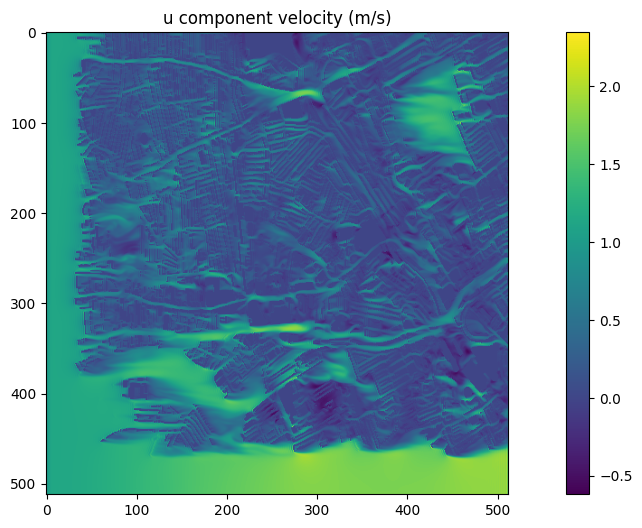

In [11]:
plt.figure(figsize=(15, 6))
plt.imshow(-values_u[0,0,4,:,:].cpu())
plt.colorbar()
plt.title('u component velocity (m/s)')
# plt.axis('off')

## Visualise v component velocity in y direction

Text(0.5, 1.0, 'v component velocity (m/s)')

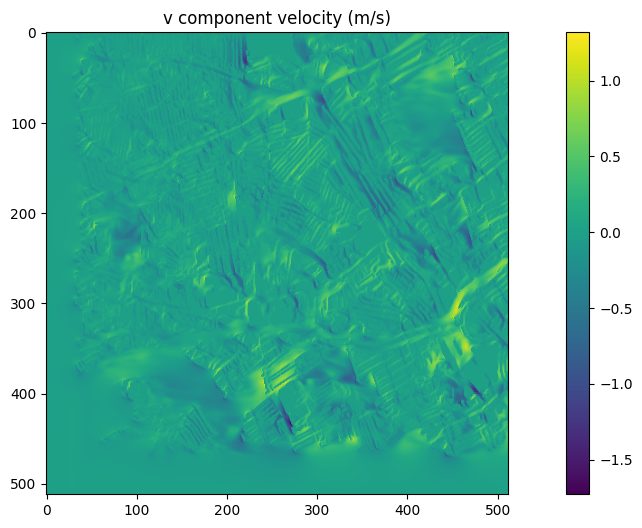

In [12]:
plt.figure(figsize=(15, 6))
plt.imshow(-values_v[0,0,4,:,:].cpu())
plt.colorbar()
plt.title('v component velocity (m/s)')